## Task 1: Preparation and Training - Build upon the code discussed in class. Do not use pre-built solutions from the internet.
1) Read and understand the Word2Vec1 and GloVe2 papers.
2) Modify the Word2Vec (with & without negative sampling) and GloVe from the lab lecture (3 points)
- Train using a real-world corpus (suggest to categories news from nltk datset). Ensure to source this dataset from reputable public databases or repositories. It is imperative to give proper credit to the dataset source in your documentation.
- Create a function that allows dynamic modification of the window size during training. Use a window size of 2 as default.

In [1]:
import time, re, json
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import time, re, os, math
from collections import Counter
from itertools import combinations_with_replacement

In [2]:
print("numpy:", np.__version__)
print("torch:", torch.__version__)

numpy: 2.4.1
torch: 2.9.1+cpu


### Load data (nltk datset)
We use the Brown Corpus (news category) provided by NLTK.
Source: NLTK corpus module (Brown Corpus).


In [3]:
import nltk
nltk.download("brown")

from nltk.corpus import brown

def load_news_corpus(max_sentences=20000):
    sents = brown.sents(categories="news")[:max_sentences]
    corpus = []
    for sent in sents:
        toks = [w.lower() for w in sent]
        toks = [w for w in toks if re.fullmatch(r"[a-z]+", w)]
        if len(toks) >= 2:
            corpus.append(toks)
    return corpus

corpus = load_news_corpus(max_sentences=20000)
print("num sentences:", len(corpus))
print("example:", corpus[0][:20])

[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!


num sentences: 4555
example: ['the', 'fulton', 'county', 'grand', 'jury', 'said', 'friday', 'an', 'investigation', 'of', 'recent', 'primary', 'election', 'produced', 'no', 'evidence', 'that', 'any', 'irregularities', 'took']


In [4]:
# Build Vocab and numeralize
def build_vocab(corpus, min_count=5, max_vocab=30000):
    counts = Counter(w for sent in corpus for w in sent)
    items = [(w,c) for w,c in counts.items() if c >= min_count]
    items.sort(key=lambda x: x[1], reverse=True)
    items = items[:max_vocab]

    vocabs = [w for w,_ in items]
    vocabs.append("<UNK>")

    word2index = {w:i for i,w in enumerate(vocabs)}
    index2word = {i:w for w,i in word2index.items()}
    return vocabs, word2index, index2word, counts

vocabs, word2index, index2word, raw_counts = build_vocab(corpus, min_count=5, max_vocab=30000)
voc_size = len(vocabs)
print("vocab size:", voc_size)
print("top10:", vocabs[:10])

vocab size: 2373
top10: ['the', 'of', 'and', 'to', 'a', 'in', 'for', 'that', 'is', 'was']


In [5]:
def window_schedule(step, default=2):
    if step < 1000:
        return default
    elif step < 2000:
        return default + 1
    else:
        return default + 2

In [6]:
# Prepare train data
def make_skipgrams(corpus, word2index, window_size=2):
    unk = word2index["<UNK>"]
    pairs = []

    for sent in corpus:
        sent_ids = [word2index.get(w, unk) for w in sent]
        for i in range(len(sent_ids)):
            center = sent_ids[i]
            left = max(0, i - window_size)
            right = min(len(sent_ids), i + window_size + 1)
            for j in range(left, right):
                if j == i:
                    continue
                outside = sent_ids[j]
                pairs.append([center, outside])

    return np.array(pairs, dtype=np.int64)

def random_batch_from_corpus(corpus, word2index, batch_size, window_size=2):
    unk = word2index["<UNK>"]
    centers = np.empty((batch_size,), dtype=np.int64)
    outsides = np.empty((batch_size,), dtype=np.int64)

    b = 0
    while b < batch_size:
        sent = corpus[np.random.randint(0, len(corpus))]
        if len(sent) < 2:
            continue

        ids = [word2index.get(w, unk) for w in sent]

        i = np.random.randint(0, len(ids))
        left = max(0, i - window_size)
        right = min(len(ids), i + window_size + 1)

        ctx = [j for j in range(left, right) if j != i]
        if not ctx:
            continue

        j = np.random.choice(ctx)

        centers[b] = ids[i]
        outsides[b] = ids[j]
        b += 1

    return centers, outsides


window_size = 2 
pairs = make_skipgrams(corpus, word2index, window_size=window_size)
print("num pairs:", len(pairs))
print("sample:", pairs[:5])

num pairs: 306722
sample: [[  0 719]
 [  0 124]
 [719   0]
 [719 124]
 [719 508]]


### Task 1 - Word2Vec (Skipgram)

In [7]:
# Model
class Skipgram(nn.Module):
    def __init__(self, voc_size, emb_size):
        super().__init__()
        self.embedding_center = nn.Embedding(voc_size, emb_size)
        self.embedding_outside = nn.Embedding(voc_size, emb_size)

    def forward(self, center, outside, all_vocabs):
        v_c = self.embedding_center(center)                 
        u_o = self.embedding_outside(outside)              
        U_all = self.embedding_outside(all_vocabs)       

        top = torch.exp(u_o.bmm(v_c.transpose(1,2)).squeeze(2))  

        scores_all = U_all.bmm(v_c.transpose(1,2)).squeeze(2)     
        bottom = torch.sum(torch.exp(scores_all), dim=1, keepdim=True) 

        loss = -torch.mean(torch.log(top / (bottom + 1e-12) + 1e-12))
        return loss

In [8]:
# Training
batch_size = 256
emb_size = 100
lr = 0.001
num_epochs = 10000

all_vocabs = torch.arange(voc_size).unsqueeze(0).expand(batch_size, voc_size)

model_1 = Skipgram(voc_size, emb_size)
optimizer = optim.Adam(model_1.parameters(), lr=lr)

loss_history_1 = []
start = time.time()

for epoch in range(num_epochs):
    ws = window_schedule(epoch, default=2)

    x, y = random_batch_from_corpus(corpus, word2index, batch_size, window_size=ws)

    center = torch.LongTensor(x).unsqueeze(1) 
    outside = torch.LongTensor(y).unsqueeze(1) 

    loss = model_1(center, outside, all_vocabs)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    loss_history_1.append(loss.item())

    if (epoch + 1) % 200 == 0:
        print(f"Epoch {epoch+1}/{num_epochs} | window={ws} | loss={loss.item():.4f}")
final_ws = ws    
train_time_1 = time.time() - start   
print("Training time (sec):", train_time_1)

Epoch 200/10000 | window=2 | loss=20.9125
Epoch 400/10000 | window=2 | loss=17.1505
Epoch 600/10000 | window=2 | loss=16.9473
Epoch 800/10000 | window=2 | loss=16.5738
Epoch 1000/10000 | window=2 | loss=15.0009
Epoch 1200/10000 | window=3 | loss=14.8151
Epoch 1400/10000 | window=3 | loss=13.6580
Epoch 1600/10000 | window=3 | loss=14.0713
Epoch 1800/10000 | window=3 | loss=11.5595
Epoch 2000/10000 | window=3 | loss=12.9758
Epoch 2200/10000 | window=4 | loss=11.8779
Epoch 2400/10000 | window=4 | loss=11.8688
Epoch 2600/10000 | window=4 | loss=11.5294
Epoch 2800/10000 | window=4 | loss=10.8268
Epoch 3000/10000 | window=4 | loss=11.6703
Epoch 3200/10000 | window=4 | loss=10.7424
Epoch 3400/10000 | window=4 | loss=11.2372
Epoch 3600/10000 | window=4 | loss=10.4878
Epoch 3800/10000 | window=4 | loss=10.0618
Epoch 4000/10000 | window=4 | loss=9.7447
Epoch 4200/10000 | window=4 | loss=9.3091
Epoch 4400/10000 | window=4 | loss=9.8572
Epoch 4600/10000 | window=4 | loss=9.9918
Epoch 4800/10000 | 

PCA variance ratio: [0.05883393 0.05245931]


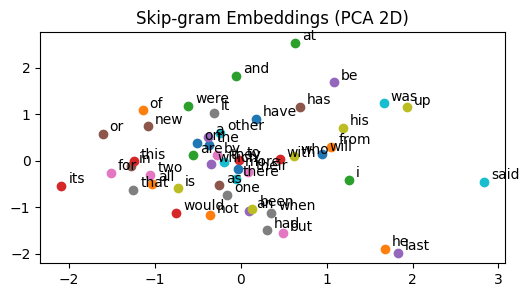

In [9]:
# Embedding
from sklearn.decomposition import PCA
def get_skipgram_embed(word):
    idx = word2index.get(word, word2index["<UNK>"])
    idx_t = torch.LongTensor([idx])

    v = model_1.embedding_center(idx_t)
    u = model_1.embedding_outside(idx_t)
    e = (v + u) / 2.0
    return e[0].detach().cpu().numpy()

words_to_plot = vocabs[:50]
embs = np.array([get_skipgram_embed(w) for w in words_to_plot])

pca = PCA(n_components=2)
embs_2d = pca.fit_transform(embs)

print("PCA variance ratio:", pca.explained_variance_ratio_)

plt.figure(figsize=(6,3))
for i, w in enumerate(words_to_plot):
    x, y = embs_2d[i]
    plt.scatter(x, y)
    plt.annotate(w, (x, y), textcoords="offset points", xytext=(5,2))

plt.title("Skip-gram Embeddings (PCA 2D)")
plt.show()

### Task 1 - Word2Vec (Negative Sampling)

In [10]:
# Negative Sampling
raw_counts = Counter([w for sent in corpus for w in sent])
vocab_counts = np.array([raw_counts.get(w, 0) for w in vocabs], dtype=np.int64)

def neg_sampling_prob(vocab_counts, power=0.75):
    p = vocab_counts.astype(np.float64) ** power
    p = p / (p.sum() + 1e-12)
    return p

neg_prob = neg_sampling_prob(vocab_counts, power=0.75)
neg_prob[:10], neg_prob.sum()

(array([0.03156336, 0.01728423, 0.01412535, 0.01392131, 0.01385308,
        0.01331297, 0.00767369, 0.00682618, 0.00622429, 0.00612211]),
 np.float64(1.0))

In [11]:
# Model
class SkipgramNEG(nn.Module):
    def __init__(self, voc_size, emb_size):
        super().__init__()
        self.embedding_center = nn.Embedding(voc_size, emb_size)
        self.embedding_outside = nn.Embedding(voc_size, emb_size)

    @staticmethod
    def sigmoid(x):
        return torch.sigmoid(x)

    def forward(self, center, pos_outside, neg_outsides):
        v_c = self.embedding_center(center).squeeze(1)      
        u_o = self.embedding_outside(pos_outside).squeeze(1)  
        u_n = self.embedding_outside(neg_outsides)           

        s_pos = torch.sum(v_c * u_o, dim=1)
        s_neg = torch.einsum("be,bke->bk", v_c, u_n)

        loss_pos = -torch.log(self.sigmoid(s_pos) + 1e-12)            
        loss_neg = -torch.sum(torch.log(self.sigmoid(-s_neg) + 1e-12), dim=1) 
        loss = torch.mean(loss_pos + loss_neg)
        return loss
def sample_negatives(batch_size, K, neg_prob, avoid_ids=None, seed=None):
    rng = np.random.default_rng(seed)
    negs = rng.choice(len(neg_prob), size=(batch_size, K), replace=True, p=neg_prob)
    if avoid_ids is not None:
        for i in range(batch_size):
            for k in range(K):
                while negs[i, k] == avoid_ids[i]:
                        negs[i, k] = rng.choice(len(neg_prob), p=neg_prob)
    return negs

In [12]:
# Training
batch_size = 256
emb_size = 100
lr = 0.002
num_epochs = 10000
K = 10

model_2 = SkipgramNEG(voc_size, emb_size)
optimizer = optim.Adam(model_2.parameters(), lr=lr)

loss_history_2 = []
start = time.time()

for epoch in range(num_epochs):
    ws = window_schedule(epoch, default=2)
    cx, oy = random_batch_from_corpus(corpus, word2index, batch_size, window_size=ws)

    center = torch.LongTensor(cx)  
    pos    = torch.LongTensor(oy) 

    negs_np = sample_negatives(batch_size, K, neg_prob, avoid_ids=pos.numpy())
    negs = torch.LongTensor(negs_np)  

    loss = model_2(center.unsqueeze(1), pos.unsqueeze(1), negs)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    loss_history_2.append(loss.item())

    if (epoch + 1) % 200 == 0:
        print(f"Epoch {epoch+1:4d}/{num_epochs} | window={ws} | Loss: {loss.item():.4f}")
final_ws = ws
train_time_2 = time.time() - start
print("Training time (sec):", train_time_2)

Epoch  200/10000 | window=2 | Loss: 32.0631
Epoch  400/10000 | window=2 | Loss: 26.5296
Epoch  600/10000 | window=2 | Loss: 23.1268
Epoch  800/10000 | window=2 | Loss: 18.3090
Epoch 1000/10000 | window=2 | Loss: 18.4636
Epoch 1200/10000 | window=3 | Loss: 14.0734
Epoch 1400/10000 | window=3 | Loss: 11.4697
Epoch 1600/10000 | window=3 | Loss: 10.7445
Epoch 1800/10000 | window=3 | Loss: 9.1104
Epoch 2000/10000 | window=3 | Loss: 8.2673
Epoch 2200/10000 | window=4 | Loss: 6.4858
Epoch 2400/10000 | window=4 | Loss: 7.6553
Epoch 2600/10000 | window=4 | Loss: 6.1263
Epoch 2800/10000 | window=4 | Loss: 5.7547
Epoch 3000/10000 | window=4 | Loss: 5.7738
Epoch 3200/10000 | window=4 | Loss: 5.2372
Epoch 3400/10000 | window=4 | Loss: 4.6180
Epoch 3600/10000 | window=4 | Loss: 4.3980
Epoch 3800/10000 | window=4 | Loss: 4.1606
Epoch 4000/10000 | window=4 | Loss: 3.9323
Epoch 4200/10000 | window=4 | Loss: 4.2297
Epoch 4400/10000 | window=4 | Loss: 3.7462
Epoch 4600/10000 | window=4 | Loss: 3.7581
Epo

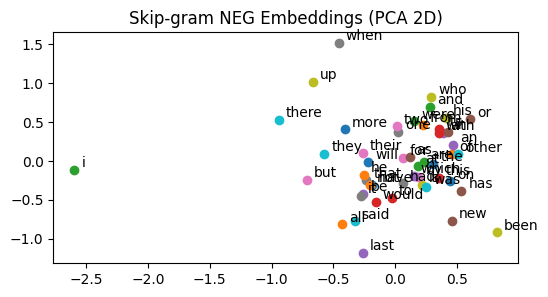

In [13]:
# Embedding
def get_neg_embed(word):
    idx = word2index.get(word, word2index["<UNK>"])
    idx_t = torch.LongTensor([idx])

    v = model_2.embedding_center(idx_t)
    u = model_2.embedding_outside(idx_t)
    e = (v + u) / 2.0
    return e[0].detach().cpu().numpy()

words_to_plot = vocabs[:50]
embs = np.array([get_neg_embed(w) for w in words_to_plot])

pca = PCA(n_components=2)
embs_2d = pca.fit_transform(embs)

plt.figure(figsize=(6,3))
for i, w in enumerate(words_to_plot):
    x, y = embs_2d[i]
    plt.scatter(x, y)
    plt.annotate(w, (x, y), textcoords="offset points", xytext=(5,2))

plt.title("Skip-gram NEG Embeddings (PCA 2D)")
plt.show()

### Task 1 - GloVE

In [14]:
def build_glove_stats_from_pairs(pairs, x_max=100, alpha=0.75):
    X_ik_skipgrams = Counter(map(tuple, pairs))

    X_ik = {}
    weighting_dic = {}

    def weighting(i, j):
        x_ij = X_ik.get((i, j), 1.0)
        return (x_ij / x_max) ** alpha if x_ij < x_max else 1.0

    for (wi, wj), co in X_ik_skipgrams.items():
        X_ik[(wi, wj)] = float(co) + 1.0
        weighting_dic[(wi, wj)] = weighting(wi, wj)

    return X_ik, weighting_dic

In [15]:
# Prepare train data
def random_batch_glove(batch_size, pairs, X_ik, weighting_dic):
    rand_idx = np.random.choice(len(pairs), batch_size, replace=False)
    batch_pairs = pairs[rand_idx]                

    inputs = batch_pairs[:, 0:1].astype(np.int64) 
    labels = batch_pairs[:, 1:2].astype(np.int64) 

    coocs = np.empty((batch_size, 1), dtype=np.float32)
    weightings = np.empty((batch_size, 1), dtype=np.float32)

    for n, (i, j) in enumerate(batch_pairs):
        x_ij = X_ik.get((int(i), int(j)), 1.0)
        coocs[n, 0] = math.log(x_ij)

        w_ij = weighting_dic.get((int(i), int(j)), 1.0)
        weightings[n, 0] = w_ij

    return inputs, labels, coocs, weightings


In [16]:
# Model
class Glove(nn.Module):
    def __init__(self, voc_size, emb_size):
        super().__init__()
        self.center_embedding = nn.Embedding(voc_size, emb_size)
        self.outside_embedding = nn.Embedding(voc_size, emb_size)

        self.center_bias = nn.Embedding(voc_size, 1)
        self.outside_bias = nn.Embedding(voc_size, 1)

    def forward(self, center, outside, coocs, weighting):

        v_i = self.center_embedding(center)              
        v_j = self.outside_embedding(outside)             

        b_i = self.center_bias(center).squeeze(1)        
        b_j = self.outside_bias(outside).squeeze(1)        

        inner = v_j.bmm(v_i.transpose(1, 2)).squeeze(2)     
        loss = weighting * torch.pow(inner + b_i + b_j - coocs, 2)

        return torch.sum(loss)  

In [17]:
# Training
batch_size = 512
embedding_size = 100
lr = 0.001
num_epochs = 10000

model_3 = Glove(voc_size, embedding_size)
optimizer = optim.Adam(model_3.parameters(), lr=lr)

loss_history_3 = []
start_train = time.time()

current_ws = None

for epoch in range(num_epochs):
    ws = window_schedule(epoch, default=2)

    if ws != current_ws:
        current_ws = ws
        pairs_ws = make_skipgrams(corpus, word2index, window_size=current_ws)
        X_ik, weighting_dic = build_glove_stats_from_pairs(pairs_ws)
        print(f"window={current_ws} pairs={len(pairs_ws)} X_ik={len(X_ik)}")

    xb, yb, coocb, wb = random_batch_glove(batch_size, pairs_ws, X_ik, weighting_dic)

    xb = torch.LongTensor(xb)
    yb = torch.LongTensor(yb)
    coocb = torch.FloatTensor(coocb)
    wb = torch.FloatTensor(wb)

    optimizer.zero_grad()
    loss = model_3(xb, yb, coocb, wb)
    loss.backward()
    optimizer.step()

    loss_history_3.append(loss.item())

    if (epoch + 1) % 500 == 0:
        print(f"Epoch {epoch+1}/{num_epochs} | window={current_ws} | loss: {loss.item():.6f}")
final_ws = ws
train_time_3 = time.time() - start_train
print("Training time (sec):", train_time_3)

window=2 pairs=306722 X_ik=102768
Epoch 500/10000 | window=2 | loss: 4411.043945
Epoch 1000/10000 | window=2 | loss: 2382.850830
window=3 pairs=446726 X_ik=140058
Epoch 1500/10000 | window=3 | loss: 2054.357178
Epoch 2000/10000 | window=3 | loss: 1296.551514
window=4 pairs=578216 X_ik=171908
Epoch 2500/10000 | window=4 | loss: 1195.437012
Epoch 3000/10000 | window=4 | loss: 934.787170
Epoch 3500/10000 | window=4 | loss: 905.150574
Epoch 4000/10000 | window=4 | loss: 559.218140
Epoch 4500/10000 | window=4 | loss: 544.873535
Epoch 5000/10000 | window=4 | loss: 400.568359
Epoch 5500/10000 | window=4 | loss: 356.861359
Epoch 6000/10000 | window=4 | loss: 298.395721
Epoch 6500/10000 | window=4 | loss: 266.138184
Epoch 7000/10000 | window=4 | loss: 209.243607
Epoch 7500/10000 | window=4 | loss: 234.249435
Epoch 8000/10000 | window=4 | loss: 163.829361
Epoch 8500/10000 | window=4 | loss: 171.647354
Epoch 9000/10000 | window=4 | loss: 115.865273
Epoch 9500/10000 | window=4 | loss: 118.166176
E

PCA variance ratio: [0.05597313 0.05199989]


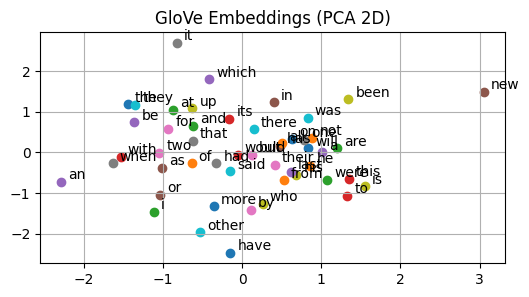

In [18]:
def get_glove_embed(word):
    idx = word2index.get(word, word2index["<UNK>"])
    idx_t = torch.LongTensor([idx])

    v = model_3.center_embedding(idx_t)
    u = model_3.outside_embedding(idx_t)
    e = (v + u) / 2.0
    return e[0].detach().cpu().numpy()

words_to_plot = vocabs[:50] 
embs = np.array([get_glove_embed(w) for w in words_to_plot])

pca = PCA(n_components=2)
embs_2d = pca.fit_transform(embs)

print("PCA variance ratio:", pca.explained_variance_ratio_)

plt.figure(figsize=(6,3))
for i, w in enumerate(words_to_plot):
    x, y = embs_2d[i]
    plt.scatter(x, y)
    plt.annotate(w, (x, y), textcoords="offset points", xytext=(5,2))

plt.title("GloVe Embeddings (PCA 2D)")
plt.grid(True)
plt.show()

### Save embeddings

In [19]:
def export_embeddings_skipgram(model):
    Wc = model.embedding_center.weight.detach().cpu().numpy()
    Wo = model.embedding_outside.weight.detach().cpu().numpy()
    return (Wc + Wo) / 2.0

# Save Skipgram Softmax
emb = export_embeddings_skipgram(model_1)

save_path = os.path.join(".", "models", f"skipgram_softmax_w{final_ws}.npz")
os.makedirs(os.path.dirname(save_path), exist_ok=True)

np.savez(save_path,emb=emb,vocabs=np.array(vocabs, dtype=object),window_size=final_ws,
    emb_size=emb_size,lr=lr,num_epochs=num_epochs,train_time=train_time_1)
print("Saved to:", save_path)


# Save Skipgram NEG
emb = export_embeddings_skipgram(model_2)

save_path = os.path.join(".", "models", f"skipgram_neg_w{final_ws}.npz")
os.makedirs(os.path.dirname(save_path), exist_ok=True)

np.savez(save_path,emb=emb,vocabs=np.array(vocabs, dtype=object),window_size=final_ws,
    emb_size=emb_size,lr=lr,num_epochs=num_epochs,train_time=train_time_2)
print("Saved to:", save_path)


# Save GloVe Scratch
def export_embeddings_glove(model):
    Wc = model.center_embedding.weight.detach().cpu().numpy()
    Wo = model.outside_embedding.weight.detach().cpu().numpy()
    return (Wc + Wo) / 2.0

emb = export_embeddings_glove(model_3)

save_path = os.path.join(".", "models", f"glove_scratch_w{final_ws}.npz")
os.makedirs(os.path.dirname(save_path), exist_ok=True)

np.savez(save_path,emb=emb,vocabs=np.array(vocabs, dtype=object),window_size=final_ws,
    emb_size=embedding_size,lr=lr,num_epochs=num_epochs,train_time=train_time_3)
print("Saved to:", save_path)

Saved to: .\models\skipgram_softmax_w4.npz
Saved to: .\models\skipgram_neg_w4.npz
Saved to: .\models\glove_scratch_w4.npz
